In [ ]:
# # uncomment and run this if you are in Colab
# # and want to run this notebook
# !git clone https://github.com/nguwijy/deep_branching_with_domain
# %cd deep_branching_with_domain
# !python setup.py install
# import site
# site.main()

In [1]:
import os
import sys
import numbers
import math
import time
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.colors
from matplotlib import cm 
import numpy as np
from scipy.stats import norm
from functools import partial
from IPython.display import Markdown as md
# add parent directory to system so that we can import the modules correctly
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from branch.branch import Net
from branch.galerkin import DGMNet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# the formula given by Borodin, see compare_boundary_method.ipynb fore more information
def conditional_probability_to_survive(
    t,
    x,
    y,
    k_arr=range(-5, 5),
    lower_bound=-10,
    upper_bound=10,
):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose (t, x, y)
    # so that the operation with lower_bound, upper_bound is correct
    t = t.unsqueeze(dim=0).transpose(0, -1)
    x, y = x.transpose(0, -1), y.transpose(0, -1)

    # calculate the probability using the formula by Borodin
    ans = 0
    for k in k_arr:
        ans += (
            torch.exp(
                ((y - x) ** 2 - (y - x + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
            - torch.exp(
                ((y - x) ** 2 - (y + x - 2*lower_bound + 2*k*(upper_bound-lower_bound)) ** 2) 
                / (2 * t)
            )
        )
    return ans.transpose(0, -1).prod(dim=0)

def is_x_inside(x, lower_bound=-10, upper_bound=10):
    # in case lower_bound & upper_bound are not tensor
    if not torch.is_tensor(lower_bound):
        lower_bound = torch.tensor(lower_bound, device=device)
    if not torch.is_tensor(upper_bound):
        upper_bound = torch.tensor(upper_bound, device=device)

    # transpose x so that the operation with lower_bound, upper_bound is correct
    x = x.transpose(0, -1)

    return (
        torch.logical_and(lower_bound <= x, x <= upper_bound)
        .transpose(0, -1).all(dim=0)
    )

# Navier-Stokes equation
We consider the 2D Navier-Stokes equation inside the square $[-1, 1]^2$. For this, we let the wall be the horizontal lines $y = -1$ and $y = 1$ and impose 0 pressure and 0 velocity at the wall.

Recall that the velocity satisfies
$$
\partial_t u(t,x) + \nu \Delta u(t,x) =\nabla p(t,x) + ( u \cdot \nabla ) u,
$$
with the divergence free condition ${\rm div \ \! } u = 0$.

We use the terminal condition of
$$
\begin{cases}
\phi_0(x) &= \frac{f'(x_1)}{f(x_1)} \exp\left( -\frac{g(x_0)}{f(x_1)} \right),
\\
\phi_1(x) &= \frac{g'(x_0)}{g(x_0)} \exp\left( -\frac{g(x_0)}{f(x_1)} \right),
\end{cases}
$$
where
$f(x) = (1-x)^\alpha (1+x)^\beta$
and
$g(x) = 1 + x^2$.
It can be checked that the terminal condition satisfies the divergence free condition.

In [3]:
problem_name = "navier_stokes_2d_with_boundary"
alpha_for_f, beta_for_f = 2, 2

def f(x):
    return (1-x)**alpha_for_f * (1+x)**beta_for_f

def fprime(x):
    return (
        ((beta_for_f - alpha_for_f) - (beta_for_f + alpha_for_f) * x)
        * (1-x)**(alpha_for_f-1) 
        * (1+x)**(beta_for_f-1)
    )

def g(x):
    return 1 + x**2

def gprime(x):
    return 2 * x

t_lo, x_lo, x_hi = 0., -1, 1

# function definition
deriv_map = np.array(
    [
        [1, 0],  # for nabla p
        [0, 1],
        [0, 0],  # for u
        [0, 0],
        [1, 0],  # for nabla u1
        [0, 1],
        [1, 0],  # for nabla u2
        [0, 1],
    ]
)
zeta_map = np.array([-1, -1, 0, 1, 0, 0, 1, 1])
deriv_condition_deriv_map = np.array(
    [
        [1, 0],
        [0, 1],
    ]
)
deriv_condition_zeta_map = np.array([0, 1])
_, dim = deriv_map.shape

def f_example(y, coordinate):
    """
    idx 0 -> no deriv
    """
    f = -y[coordinate]
    for j in range(dim):
        f += -y[dim + j] * y[2 * dim + dim * coordinate + j]
    return f

def phi_example(x, coordinate):
    if coordinate == 0:
        return fprime(x[1]) / f(x[1]) * torch.exp(-g(x[0]) / f(x[1]))
    else:
        return gprime(x[0]) / g(x[0]) * torch.exp(-g(x[0]) / f(x[1]))

def plot_wall(model, nb_spatial, x_lo, x_hi):
    lw, delta = 5, 1e-1
    plt.axis('scaled')
    plt.xlim(x_lo, x_hi)
    plt.ylim(x_lo, x_hi)
#     wall = np.linspace(x_lo, x_hi + delta, nb_spatial)
#     wall_lo = x_lo * np.ones_like(wall)
#     wall_hi = x_hi * np.ones_like(wall)
#     plt.plot(wall, wall_lo, color="black",linewidth=lw)
#     plt.plot(wall, wall_hi, color="black",linewidth=lw)

def plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u, nb_spatial, vmin=None, vmax=None, plt_velocity=True):
    # for velocity, the magnitute is the length
    # for pressure, the magnitute is simply itself
    magnitute = torch.sqrt(u[0]**2 + u[1]**2) if plt_velocity else u[0]
    subject = "velocity" if plt_velocity else "pressure"
    f = plt.figure()
    s = f.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        magnitute.reshape(nb_spatial, nb_spatial),
        cmap=cmap,
        extent=(x_lo, x_hi, x_lo, x_hi),
        origin='lower',
        vmin=vmin,
        vmax=vmax,
    )
    f.colorbar(im)
    plot_wall(model, nb_spatial, x_lo, x_hi)
    
    if plt_velocity:
        # use coarser grid
        x1 = x1.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        x2 = x2.reshape(nb_spatial, nb_spatial)[::5, ::5].reshape(-1)
        u = u.reshape(2, nb_spatial, nb_spatial)[:, ::5, ::5].reshape(2, -1)
        plt.quiver(x1, x2, u[0], u[1], scale=10*(vmax - vmin))
        plt.title(f"{subject} flow at t = {tt}")
    plt.title(f"{subject} flow at t = {tt}")
    f.savefig(f"../{model.working_dir}/plot/t{tt}_{subject}.png", bbox_inches="tight", dpi=300)
    if isinstance(tt, numbers.Number) and (math.isclose(tt, model.t_lo) or math.isclose(tt, model.T)):
        plt.show()
    plt.close()

def plot_fluid(model, nb_time=21, nb_spatial=101, x_lo=None, x_hi=None):
    x_lo = model.x_lo if x_lo is None else x_lo
    x_hi = model.x_hi if x_hi is None else x_hi
    x1, x2 = np.meshgrid(
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1],
        np.linspace(x_lo, x_hi, nb_spatial + 2)[1:-1]
    )
    x1, x2 = x1.reshape(-1), x2.reshape(-1)
    time_arr = np.linspace(model.t_lo, model.T, nb_time)
    u = []
    for tt in time_arr:
        # create x
        x_tensor = torch.tensor(
            np.stack((tt * np.ones_like(x1), x1, x2)),
            device=model.device,
            dtype=torch.get_default_dtype()
        ).reshape(3, -1)
    
        # calculate u
        u.append(model(x_tensor.T, patch=0).T.detach().cpu())
    # merge all u together
    u = torch.stack(u, dim=0)
    
    # calculate terminal u & p
    terminal_u = torch.stack((
        model.phi_fun(x_tensor[1:], 0).cpu(),
        model.phi_fun(x_tensor[1:], 1).cpu(),
    ))
    p = model(x_tensor[1:].T, patch=0, p_or_u="p").T.detach().cpu()
    
    # plot
    magnitute = torch.sqrt(u[:, 0, :]**2 + u[:, 1, :]**2)
    magnitute = magnitute[~magnitute.isnan()]  # filter nan
    vmin, vmax = magnitute.min().item(), magnitute.max().item()
    for idx, tt in enumerate(time_arr):
        plot_quiver_and_color(model, tt, x_lo, x_hi, x1, x2, u[idx], nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, "terminal", x_lo, x_hi, x1, x2, terminal_u, nb_spatial, vmin, vmax)
    plot_quiver_and_color(model, model.T, x_lo, x_hi, x1, x2, p, nb_spatial, plt_velocity=False)
    
    return x1, x2, u, p

In [4]:
# checking the consistency of PDE
def check_poisson(model, nb_points=100, x_lo=None, x_hi=None):
    # create x
    x_lo = model.x_lo if x_lo is None else x_lo
    x_hi = model.x_hi if x_hi is None else x_hi
    x1, x2 = np.meshgrid(
        np.linspace(x_lo, x_hi, nb_points + 2)[1:-1],
        np.linspace(x_lo, x_hi, nb_points + 2)[1:-1]
    )
    x_tensor = torch.tensor(
        np.stack((x1, x2)),
        device=model.device,
        dtype=torch.get_default_dtype(),
        requires_grad=True,
    ).reshape(2, -1)

    # calculate poisson rhs and lhs
    poisson_rhs = 0
    order = np.array([0] * model.dim_in)
    # xx = x.T.detach().clone().requires_grad_(True)
    for i in range(model.dim_in):
        for j in range(model.dim_in):
            order[i] += 1
            tmp = model.nth_derivatives(
                order, model.phi_fun(x_tensor, j), x_tensor
            )
            order[i] -= 1
            order[j] += 1
            tmp *= model.nth_derivatives(
                order, model.phi_fun(x_tensor, i), x_tensor
            )
            order[j] -= 1
            poisson_rhs -= tmp
    poisson_rhs = poisson_rhs.reshape(nb_points, nb_points).detach().cpu()
    poisson_lhs = 0
    for i in range(model.dim_in):
        order[i] += 2
        poisson_lhs += model.nth_derivatives(
            order, model(x_tensor.T, p_or_u="p", patch=0), x_tensor
        )
        order[i] -= 2
    poisson_lhs = poisson_lhs.reshape(nb_points, nb_points).detach().cpu()

    # plot
    fig = plt.figure()
    s = fig.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        poisson_lhs,
        cmap=cmap,
        extent=(model.x_lo, model.x_hi, model.x_lo, model.x_hi),
        origin='lower')
    fig.colorbar(im)
    plt.title("Poisson LHS, Laplacian p")
    plt.show()
    plt.close()

    fig = plt.figure()
    s = fig.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        poisson_rhs,
        cmap=cmap,
        extent=(model.x_lo, model.x_hi, model.x_lo, model.x_hi),
        origin='lower')
    fig.colorbar(im)
    plt.title("Poisson RHS, -div div u x u")
    plt.show()
    plt.close()
    
    return poisson_lhs, poisson_rhs

def check_divergence(model, t=0, nb_points=100, x_lo=None, x_hi=None):
    # create x
    x_lo = model.x_lo if x_lo is None else x_lo
    x_hi = model.x_hi if x_hi is None else x_hi
    x1, x2 = np.meshgrid(
        np.linspace(x_lo, x_hi, nb_points + 2)[1:-1],
        np.linspace(x_lo, x_hi, nb_points + 2)[1:-1]
    )
    x_tensor = torch.tensor(
        np.stack((t*np.ones_like(x1), x1, x2)),
        device=model.device,
        dtype=torch.get_default_dtype(),
        requires_grad=True,
    ).reshape(3, -1)
    
    grad = 0
    for (idx, c) in zip(model.deriv_condition_zeta_map, model.deriv_condition_deriv_map):
        # additional t coordinate
        grad += model.nth_derivatives(
            np.insert(c, 0, 0), model(x_tensor.T, patch=0)[:, idx], x_tensor
        )
    grad = grad.reshape(nb_points, nb_points).detach().cpu()

    # plot
    fig = plt.figure()
    s = fig.add_subplot(1, 1, 1, xlabel='$x$', ylabel='$y$')
    cmap=cm.coolwarm
    im = s.imshow(
        grad,
        cmap=cmap,
        extent=(model.x_lo, model.x_hi, model.x_lo, model.x_hi),
        origin='lower')
    fig.colorbar(im)
    plt.title(f"Div(u) at t = {t}")
    plt.show()
    plt.close()
    
    return grad

## beta = 2, T = 20

In [5]:
# use the trained model below
nu = .002
patches = 1
T = patches * 20
MAX_VAL = 100
beta_for_f = 2

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    conditional_probability_to_survive_for_p=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside_for_p=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,  # change to 100000
    branch_nb_states_per_batch=1000,
    epochs=10000,  # change to 10000
    fix_all_dim_except_first=False,
    fix_t_dim=False,
    overtrain_rate=0.,
    outlier_multiplier=10,
    save_as_tmp=False,  # change to False
    poisson_coeff=0.,
    div_condition_coeff=0.,
    continue_from_checkpoint="logs/20220606-172930-navier_stokes_2d_with_boundary-T10-nu0.002",
)
model.train_and_eval(debug_mode=False)

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/20220607-114112-navier_stokes_2d_with_boundary-T20-nu0.002
Patch 0: generation of u samples take 3245.5019204616547 seconds.
Patch  0: epoch    0 with loss 1.95E-02
Patch  0: epoch  500 with loss 6.08E-03
Patch  0: epoch 1000 with loss 6.07E-03
Patch  0: epoch 1500 with loss 6.02E-03
Patch  0: epoch 2000 with loss 6.01E-03
Patch  0: epoch 2500 with loss 6.00E-03
Patch  0: epoch 3000 with loss 6.10E-03
Patch  0: epoch 3500 with loss 5.99E-03
Patch  0: epoch 4000 with loss 6.19E-03
Patch  0: epoch 4500 with loss 5.98E-03
Patch  0: epoch 5000 with loss 5.98E-03
Patch  0: epoch 5500 with loss 5.98E-03
Patch  0: epoch 6000 with loss 5.98E-03
Patch  0: epoch 6500 with loss 5.98E-03
Patch  0: epoch 7000 with loss 5.97E-03
Patch  0: epoch 7500 with loss 5.97E-03
Patch  0: epoch 8000 with loss 5.98E-03
Patch  0: epoch 8500 with loss 6.03E-03
Patch  0: epoch 9000 with loss 5.96E-03
Patch  0: epoch 9500 with loss 5.96E-03
Patch 

[Link to log directory:](../logs/20220607-114112-navier_stokes_2d_with_boundary-T20-nu0.002)

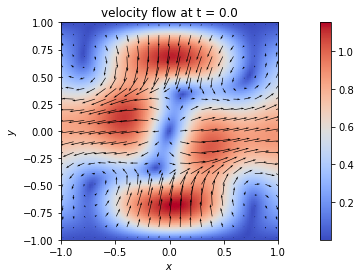

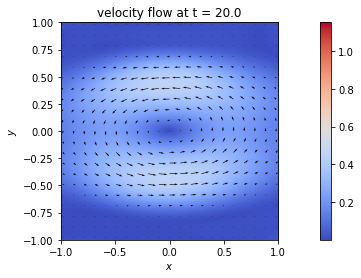

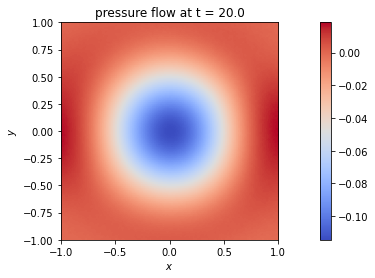

In [19]:
x1, x2, u, p = plot_fluid(model, nb_time=41)

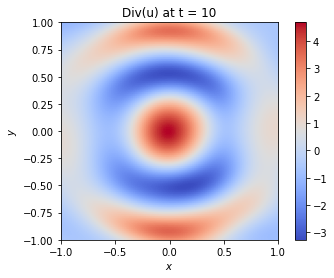

The L2 loss of the divergence is 2.55E+00.


In [17]:
# We check the divergence free condition
grad = check_divergence(model)
print(f"The L2 loss of the divergence is {model.loss(grad, torch.zeros_like(grad)):.2E}.")

The gif of simulated flow:
![velocity](../logs/20220607-114112-navier_stokes_2d_with_boundary-T20-nu0.002/plot/velocity.gif "velocity")

## beta = 2, T = 10

In [5]:
nu = .002
patches = 1
T = patches * 10
MAX_VAL = 100
beta_for_f = 2

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    conditional_probability_to_survive_for_p=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside_for_p=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,  # change to 100000
    branch_nb_states_per_batch=1000,
    epochs=10000,  # change to 10000
    fix_all_dim_except_first=False,
    fix_t_dim=False,
    overtrain_rate=0.,
    outlier_multiplier=10,
    save_as_tmp=False,  # change to False
    train_for_u=False,
    poisson_coeff=0.,
    div_condition_coeff=0.,
)
model.train_and_eval(debug_mode=False)

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/20220606-172930-navier_stokes_2d_with_boundary-T10-nu0.002
Patch 0: generation of p samples take 1967.5004377365112 seconds.
Patch  0: epoch    0 with loss 1.79E+00
Patch  0: epoch  500 with loss 1.18E-04
Patch  0: epoch 1000 with loss 8.93E-05
Patch  0: epoch 1500 with loss 7.51E-05
Patch  0: epoch 2000 with loss 6.52E-05
Patch  0: epoch 2500 with loss 5.61E-05
Patch  0: epoch 3000 with loss 4.96E-05
Patch  0: epoch 3500 with loss 4.75E-05
Patch  0: epoch 4000 with loss 4.01E-05
Patch  0: epoch 4500 with loss 3.50E-05
Patch  0: epoch 5000 with loss 3.12E-05
Patch  0: epoch 5500 with loss 2.61E-05
Patch  0: epoch 6000 with loss 2.34E-05
Patch  0: epoch 6500 with loss 2.10E-05
Patch  0: epoch 7000 with loss 1.12E-03
Patch  0: epoch 7500 with loss 2.69E-04
Patch  0: epoch 8000 with loss 1.10E-05
Patch  0: epoch 8500 with loss 4.03E-05
Patch  0: epoch 9000 with loss 8.32E-06
Patch  0: epoch 9500 with loss 3.18E-05
Patch 

[Link to log directory:](../logs/20220606-172930-navier_stokes_2d_with_boundary-T10-nu0.002)

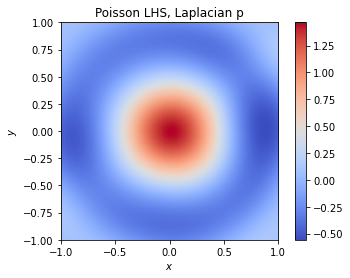

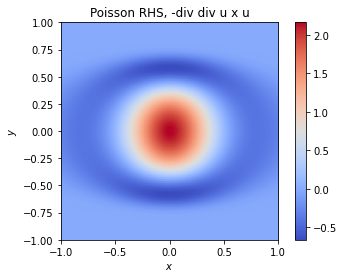

The L2 difference between LHS and RHS is 7.26E-02.


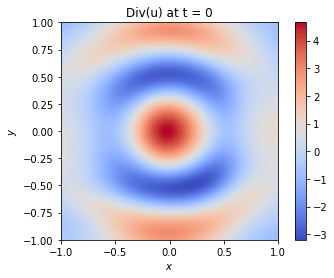

The L2 loss of the divergence is 2.25E+00.


In [6]:
# We check the consistency of Poisson equation and the divergence free condition
lhs, rhs = check_poisson(model)
print(f"The L2 difference between LHS and RHS is {model.loss(lhs, rhs):.2E}.")
grad = check_divergence(model)
print(f"The L2 loss of the divergence is {model.loss(grad, torch.zeros_like(grad)):.2E}.")

In [7]:
# continue training for u
model.train_for_p = False
model.train_for_u = True
model.train_and_eval(debug_mode=False)

Patch 0: generation of u samples take 3294.716639280319 seconds.
Patch  0: epoch    0 with loss 5.39E+00
Patch  0: epoch  500 with loss 8.88E-03
Patch  0: epoch 1000 with loss 4.48E-03
Patch  0: epoch 1500 with loss 2.54E-03
Patch  0: epoch 2000 with loss 2.09E-03
Patch  0: epoch 2500 with loss 1.94E-03
Patch  0: epoch 3000 with loss 2.06E-03
Patch  0: epoch 3500 with loss 1.79E-03
Patch  0: epoch 4000 with loss 1.74E-03
Patch  0: epoch 4500 with loss 1.70E-03
Patch  0: epoch 5000 with loss 2.00E-03
Patch  0: epoch 5500 with loss 1.65E-03
Patch  0: epoch 6000 with loss 1.63E-03
Patch  0: epoch 6500 with loss 2.58E-03
Patch  0: epoch 7000 with loss 1.60E-03
Patch  0: epoch 7500 with loss 1.76E-03
Patch  0: epoch 8000 with loss 1.67E-03
Patch  0: epoch 8500 with loss 1.57E-03
Patch  0: epoch 9000 with loss 1.69E-03
Patch  0: epoch 9500 with loss 1.63E-03
Patch  0: epoch 9999 with loss 1.82E-03
Patch 0: training of u with 10000 epochs take 144.7103021144867 seconds.


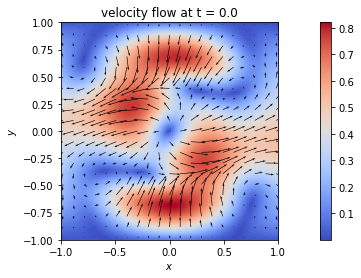

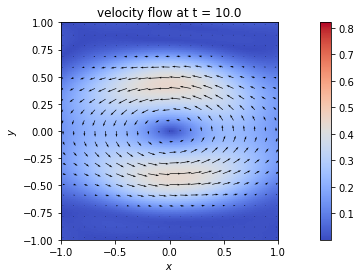

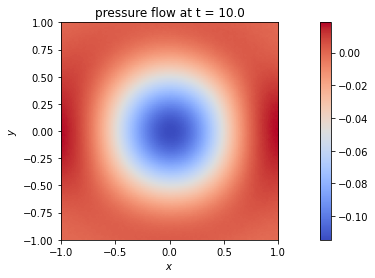

In [7]:
x1, x2, u, p = plot_fluid(model)

The gif of simulated flow:
![velocity](../logs/20220606-172930-navier_stokes_2d_with_boundary-T10-nu0.002/plot/velocity.gif "velocity")

## beta = 4, T = 10

In [9]:
nu = .002
patches = 1
T = patches * 10
MAX_VAL = 100
beta_for_f = 4

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    conditional_probability_to_survive_for_p=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside_for_p=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,  # change to 100000
    branch_nb_states_per_batch=1000,
    epochs=10000,  # change to 10000
    fix_all_dim_except_first=False,
    fix_t_dim=False,
    overtrain_rate=0.,
    outlier_multiplier=10,
    save_as_tmp=False,  # change to False
    train_for_u=False,
    poisson_coeff=0.,
    div_condition_coeff=0.,
)
model.train_and_eval(debug_mode=False)

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/20220606-190155-navier_stokes_2d_with_boundary-T10-nu0.002
Patch 0: generation of p samples take 1936.7950427532196 seconds.
Patch  0: epoch    0 with loss 1.78E+00
Patch  0: epoch  500 with loss 9.04E-04
Patch  0: epoch 1000 with loss 6.89E-04
Patch  0: epoch 1500 with loss 5.40E-04
Patch  0: epoch 2000 with loss 3.86E-04
Patch  0: epoch 2500 with loss 2.88E-04
Patch  0: epoch 3000 with loss 2.03E-04
Patch  0: epoch 3500 with loss 1.39E-04
Patch  0: epoch 4000 with loss 1.01E-04
Patch  0: epoch 4500 with loss 6.08E-05
Patch  0: epoch 5000 with loss 4.11E-05
Patch  0: epoch 5500 with loss 2.67E-05
Patch  0: epoch 6000 with loss 3.46E-05
Patch  0: epoch 6500 with loss 2.26E-04
Patch  0: epoch 7000 with loss 1.34E-05
Patch  0: epoch 7500 with loss 7.29E-05
Patch  0: epoch 8000 with loss 6.55E-05
Patch  0: epoch 8500 with loss 4.65E-06
Patch  0: epoch 9000 with loss 4.55E-06
Patch  0: epoch 9500 with loss 4.17E-06
Patch 

[Link to log directory:](../logs/20220606-190155-navier_stokes_2d_with_boundary-T10-nu0.002)

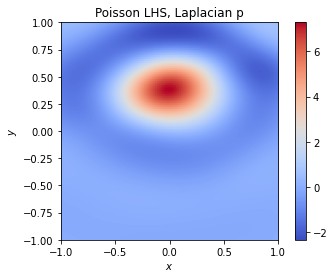

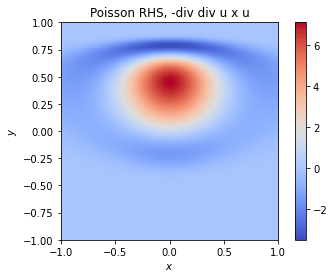

The L2 difference between LHS and RHS is 2.87E-01.


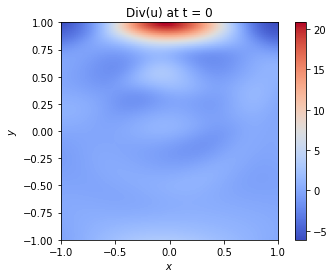

The L2 loss of the divergence is 8.52E+00.


In [9]:
# We check the consistency of Poisson equation and the divergence free condition
lhs, rhs = check_poisson(model)
print(f"The L2 difference between LHS and RHS is {model.loss(lhs, rhs):.2E}.")
grad = check_divergence(model)
print(f"The L2 loss of the divergence is {model.loss(grad, torch.zeros_like(grad)):.2E}.")

In [11]:
# continue training for u
model.train_for_p = False
model.train_for_u = True
model.train_and_eval(debug_mode=False)

Patch 0: generation of u samples take 3291.24472284317 seconds.
Patch  0: epoch    0 with loss 5.37E+00
Patch  0: epoch  500 with loss 3.20E-02
Patch  0: epoch 1000 with loss 2.81E-02
Patch  0: epoch 1500 with loss 2.71E-02
Patch  0: epoch 2000 with loss 2.66E-02
Patch  0: epoch 2500 with loss 2.62E-02
Patch  0: epoch 3000 with loss 2.60E-02
Patch  0: epoch 3500 with loss 2.58E-02
Patch  0: epoch 4000 with loss 2.56E-02
Patch  0: epoch 4500 with loss 2.57E-02
Patch  0: epoch 5000 with loss 2.54E-02
Patch  0: epoch 5500 with loss 2.53E-02
Patch  0: epoch 6000 with loss 2.53E-02
Patch  0: epoch 6500 with loss 2.52E-02
Patch  0: epoch 7000 with loss 2.52E-02
Patch  0: epoch 7500 with loss 2.51E-02
Patch  0: epoch 8000 with loss 2.62E-02
Patch  0: epoch 8500 with loss 2.52E-02
Patch  0: epoch 9000 with loss 2.53E-02
Patch  0: epoch 9500 with loss 2.54E-02
Patch  0: epoch 9999 with loss 2.50E-02
Patch 0: training of u with 10000 epochs take 134.71170854568481 seconds.


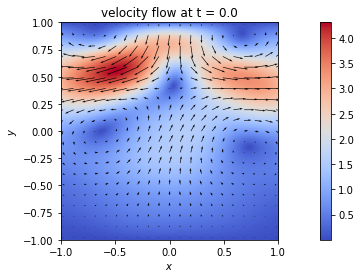

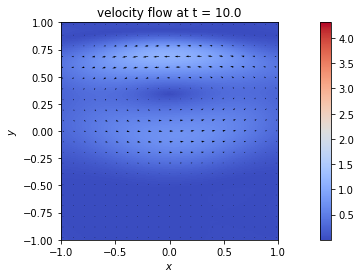

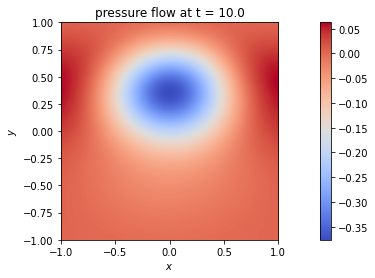

In [10]:
x1, x2, u, p = plot_fluid(model)

The gif of simulated flow:
![velocity](../logs/20220606-190155-navier_stokes_2d_with_boundary-T10-nu0.002/plot/velocity.gif "velocity")

## beta = 4, exponential g, T = 10

In [13]:
nu = .002
patches = 1
T = patches * 10
MAX_VAL = 100
beta_for_f = 4

def g(x):
    return torch.exp(-x)

def gprime(x):
    return -torch.exp(-x)

# define NN and train
torch.manual_seed(0)
model = Net(
    problem_name=problem_name,
    f_fun=f_example,
    deriv_map=deriv_map,
    zeta_map=zeta_map,
    deriv_condition_deriv_map=deriv_condition_deriv_map,
    deriv_condition_zeta_map=deriv_condition_zeta_map,
    phi_fun=phi_example,
    conditional_probability_to_survive=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    conditional_probability_to_survive_for_p=partial(
        conditional_probability_to_survive,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    is_x_inside_for_p=partial(
        is_x_inside,
        lower_bound=(-MAX_VAL, x_lo),
        upper_bound=(MAX_VAL, x_hi),
    ),
    device=device,
    x_lo=x_lo,
    x_hi=x_hi,
    T=T,
    verbose=True,
    nu=nu,
    branch_patches=patches,
    branch_nb_path_per_state=1000,
    branch_nb_states=100000,  # change to 100000
    branch_nb_states_per_batch=1000,
    epochs=10000,  # change to 10000
    fix_all_dim_except_first=False,
    fix_t_dim=False,
    overtrain_rate=0.,
    outlier_multiplier=10,
    save_as_tmp=False,  # change to False
    train_for_u=False,
    poisson_coeff=0.,
    div_condition_coeff=0.,
)
model.train_and_eval(debug_mode=False)

Logs are saved in /home/nguwijy/repo/deep_branching_with_domain/logs/20220606-205142-navier_stokes_2d_with_boundary-T10-nu0.002
Patch 0: generation of p samples take 1917.0251648426056 seconds.
Patch  0: epoch    0 with loss 2.22E+00
Patch  0: epoch  500 with loss 2.85E-03
Patch  0: epoch 1000 with loss 1.96E-03
Patch  0: epoch 1500 with loss 1.29E-03
Patch  0: epoch 2000 with loss 8.12E-04
Patch  0: epoch 2500 with loss 2.56E-04
Patch  0: epoch 3000 with loss 4.91E-04
Patch  0: epoch 3500 with loss 1.48E-04
Patch  0: epoch 4000 with loss 1.80E-04
Patch  0: epoch 4500 with loss 1.19E-04
Patch  0: epoch 5000 with loss 2.27E-04
Patch  0: epoch 5500 with loss 9.41E-05
Patch  0: epoch 6000 with loss 7.27E-05
Patch  0: epoch 6500 with loss 5.80E-05
Patch  0: epoch 7000 with loss 7.88E-05
Patch  0: epoch 7500 with loss 8.74E-05
Patch  0: epoch 8000 with loss 9.43E-05
Patch  0: epoch 8500 with loss 6.10E-05
Patch  0: epoch 9000 with loss 3.59E-05
Patch  0: epoch 9500 with loss 3.60E-05
Patch 

[Link to log directory:](../logs/20220606-205142-navier_stokes_2d_with_boundary-T10-nu0.002)

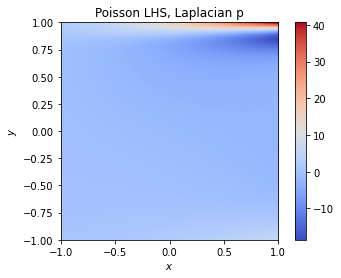

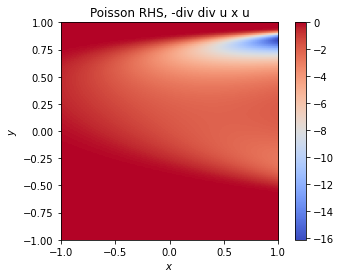

The L2 difference between LHS and RHS is 9.61E+00.


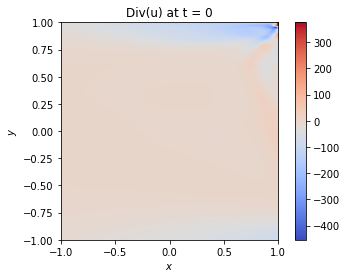

The L2 loss of the divergence is 1.02E+03.


In [13]:
# We check the consistency of Poisson equation and the divergence free condition
lhs, rhs = check_poisson(model)
print(f"The L2 difference between LHS and RHS is {model.loss(lhs, rhs):.2E}.")
grad = check_divergence(model)
print(f"The L2 loss of the divergence is {model.loss(grad, torch.zeros_like(grad)):.2E}.")

In [15]:
# continue training for u
model.train_for_p = False
model.train_for_u = True
model.train_and_eval(debug_mode=False)

Patch 0: generation of u samples take 3294.648618221283 seconds.
Patch  0: epoch    0 with loss 9.35E+01
Patch  0: epoch  500 with loss 2.97E+00
Patch  0: epoch 1000 with loss 2.92E+00
Patch  0: epoch 1500 with loss 2.92E+00
Patch  0: epoch 2000 with loss 2.90E+00
Patch  0: epoch 2500 with loss 2.90E+00
Patch  0: epoch 3000 with loss 2.89E+00
Patch  0: epoch 3500 with loss 2.89E+00
Patch  0: epoch 4000 with loss 2.89E+00
Patch  0: epoch 4500 with loss 2.89E+00
Patch  0: epoch 5000 with loss 2.89E+00
Patch  0: epoch 5500 with loss 2.89E+00
Patch  0: epoch 6000 with loss 2.88E+00
Patch  0: epoch 6500 with loss 2.88E+00
Patch  0: epoch 7000 with loss 2.88E+00
Patch  0: epoch 7500 with loss 2.89E+00
Patch  0: epoch 8000 with loss 2.88E+00
Patch  0: epoch 8500 with loss 2.86E+00
Patch  0: epoch 9000 with loss 2.86E+00
Patch  0: epoch 9500 with loss 2.85E+00
Patch  0: epoch 9999 with loss 2.84E+00
Patch 0: training of u with 10000 epochs take 122.35286545753479 seconds.


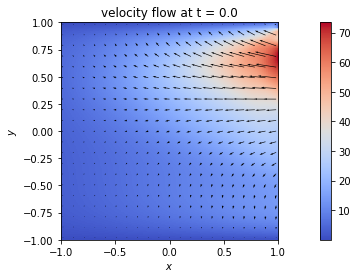

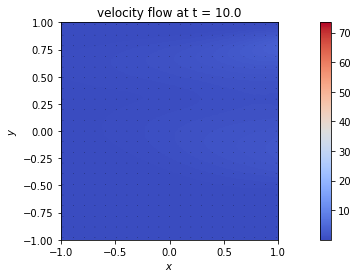

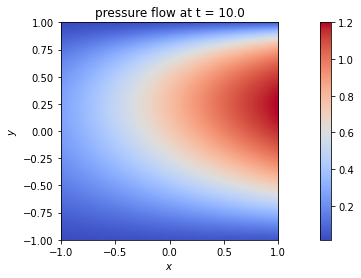

In [14]:
x1, x2, u, p = plot_fluid(model)

The gif of simulated flow:
![velocity](../logs/20220606-205142-navier_stokes_2d_with_boundary-T10-nu0.002/plot/velocity.gif "velocity")